In [57]:
from Bio.PDB import PDBParser
import numpy as np
import os
from Bio.PDB import Residue
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
path = "5jxv.pdb"
parser = PDBParser()
chain = parser.get_structure(os.path.basename(path), path).get_models().__next__().get_chains().__next__()

In [3]:
def dist(point1: np.array, point2: np.array) -> float:
    squared_sum = float(0)
    for i in range(len(point1)):
        squared_sum += np.power((point1[i] - point2[i]), 2)
    return np.sqrt(squared_sum)

In [4]:
def residue_to_dict(residue: Residue) -> dict:
    atoms = {}
    for atom in residue.get_atoms():
        atoms[atom.get_id()] = np.array(atom.get_coord())
    return atoms

In [13]:
def dssp(acceptor: Residue, donor: Residue) -> float:
    # extracting atoms and positions:
    at_donor = residue_to_dict(donor)
    at_acceptor = residue_to_dict(acceptor)

    # checking if all necessary atoms are present:
    if not "N" in at_donor.keys() or\
            not "H" in at_donor.keys() or\
            not "C" in at_acceptor.keys() or\
            not "O" in at_acceptor.keys():
        return np.nan

    # calculating distances:
    rON = dist(at_acceptor["O"], at_donor["N"])
    rCH = dist(at_acceptor["C"], at_donor["H"])
    rOH = dist(at_acceptor["O"], at_donor["H"])
    rCN = dist(at_acceptor["C"], at_donor["N"])

    # calculating energy:
    # 0.084: partial charges
    # 332: factor from paper
    # 4.184: kcal -> kj
    # result in kj/mol (paper)
    return 0.084*(1/rON + 1/rCH - 1/rOH - 1/rCN)*332*4.184

In [80]:
# iterating over all pairs of residues:
# initialize matrix E with zeroes
E = np.array([[float(0) for i in range(len(chain))] for j in range(len(chain))])
# array with residues:
residues = [residue for residue in chain.get_residues()]
for i in range(len(residues)):
    for j in range(len(residues)):
        E[i][j] = dssp(residues[i], residues[j])
E

array([[-6.49027583e+00,  1.33648402e-01, -5.88795074e-02, ...,
         4.14189457e-03, -3.25787915e-03, -7.39333125e-03],
       [-1.50358183e+01, -6.48670683e+00,  1.29671116e-01, ...,
        -8.42449391e-03,  6.30188329e-03, -1.66082895e-03],
       [-1.39423363e+00, -1.50601346e+01, -6.15638794e+00, ...,
         2.18415681e-03, -9.00986761e-03, -3.77115723e-03],
       ...,
       [ 1.55045495e-02, -7.29798687e-03, -1.41133249e-02, ...,
        -6.93886320e+00,  3.92303228e-01,  2.98470272e-02],
       [-8.29838320e-03,  1.70257760e-03,  1.61737828e-02, ...,
        -1.49983187e+01, -6.78169780e+00, -5.48193617e-01],
       [ 7.83731584e-03, -6.58367556e-03, -9.19484141e-04, ...,
        -1.59092533e+00, -1.50625461e+01, -1.91351075e+00]])

<Figure size 432x288 with 0 Axes>

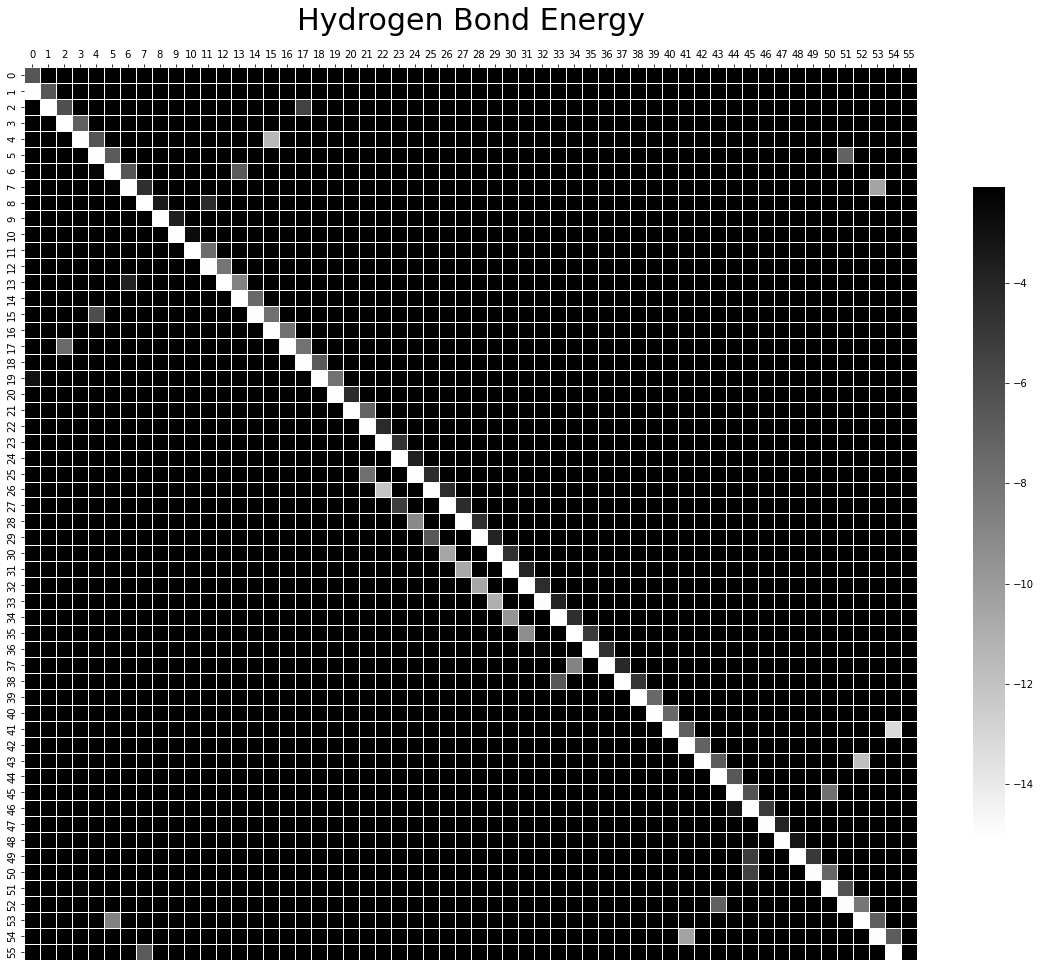

In [118]:
# creating plot
plt.figure()
plt.figure(figsize=(20,20))
im = sns.heatmap(E, vmax=-2.1, cmap="binary", linewidths=0.5, cbar=True, square=True, cbar_kws={"shrink": 0.6})
im.xaxis.tick_top()
im.set_title("Hydrogen Bond Energy", pad=20)
im.title.set_size(30)
cbar_kws={"shrink": 0.6}


#fig.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

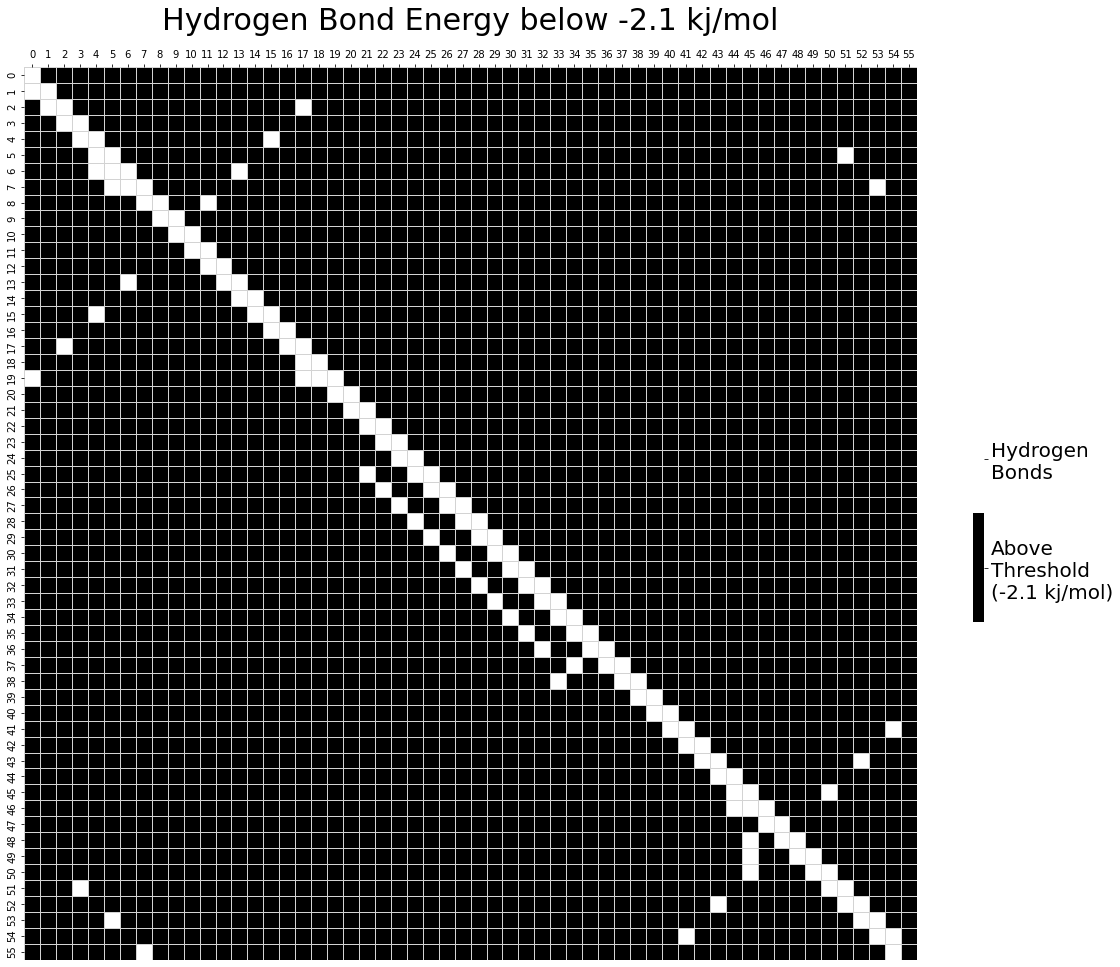

In [119]:
E1 = np.array([[1 if cell <= -2.1 else 0 for cell in row] for row in E])
colors = ((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("custom", colors, len(colors))

# creating plot
plt.figure()
plt.figure(figsize=(20,20))
im = sns.heatmap(E1, cmap=colormap, linewidths=0.5, cbar=True, square=True, center=0.5, linecolor="lightgrey", cbar_kws={"shrink": 0.2})
im.xaxis.tick_top()
im.set_title("Hydrogen Bond Energy below -2.1 kj/mol", pad=20)
im.title.set_size(30)

# setting colorbar ticks
colorbar = im.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(["Above\nThreshold\n(-2.1 kj/mol)", "Hydrogen\nBonds"])
colorbar.ax.tick_params(labelsize=20)

fig.tight_layout()
plt.show()